# Assignment 3 - SED Fitting

## Bayesian Statistics

This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Bayesian Statistics module. 

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. 

### **The goal of this assignment is to use different MCMC and Bayesian inference techniques to fit SEDs to galaxy magnitudes**

# STEP 0 - Prospector Inputs

Prospector has some in-built MCMC techniques that you will have used in Assignment 1 (Emcee or Dynesty). For this assignment you will not be using these in-built tools, instead you will use external libraries to code your own MCMC results and perform model comparison on them. We will however still use prospector for the model so lets prepare that here

### The model we are using is a very simple parametric model with 6 free parameters

* ### $z$ redshift
* ### $M_{\rm star}$ stellar mass
* ### $\log(z_{\rm sol})$ metallicity?
* ### dust V-band optical depth
* ### $t_{\rm age}$ The age of the host galaxy
* ### $\tau$


1. Activate the enviroment/kernel you used with prospector installed

2. Prepare the prospector model (if you like you can edit the below model, but you dont have to)

In [82]:
from prospect.models import SedModel, priors
from prospect.models.templates import TemplateLibrary
from prospect.sources import CSPSpecBasis
import time

model_params = TemplateLibrary["parametric_sfh"]

# Let redshift vary
model_params["zred"]["isfree"] = True
model_params['zred']['init'] = 0.1
model_params['zred']['prior'] = priors.TopHat(mini=0,maxi=1)

# Build the model
prospector_model = SedModel(model_params)

sps = CSPSpecBasis(zcontinuous=1)


In [2]:
print(model_params)

{'zred': {'N': 1, 'isfree': True, 'init': 0.1, 'units': 'redshift', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0,maxi=1), 'name': 'zred'}, 'mass': {'N': 1, 'isfree': True, 'init': 10000000000.0, 'units': 'Solar masses formed', 'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0), 'name': 'mass'}, 'logzsol': {'N': 1, 'isfree': True, 'init': -0.5, 'units': '$\\log (Z/Z_\\odot)$', 'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19), 'name': 'logzsol'}, 'dust2': {'N': 1, 'isfree': True, 'init': 0.6, 'units': 'optical depth at 5500AA', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0), 'name': 'dust2'}, 'sfh': {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index', 'name': 'sfh'}, 'tage': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8), 'name': 'tage'}, 'imf_type': {'N': 1, 'isfree': False, 'init': 2, 'name': 'imf_type'}, 'dust_ty

3. Load the data vector for a given galaxy (again you can change the gaalxy if you wish, maybe match one of your galaxies from assignment)

In [83]:
import sedpy 
import prospect
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

gal_id = 44

with fits.open('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

def build_obs(gal_id):
    """Given an object, load in fluxes, convert them to nanomaggies, and create a dict used in Prospector."""

    inp = {}
    
    # Get dataframe row for the object
    row = df.iloc[gal_id]
    inp['redshift'] = row.redshift

    # Load the filter response curves from sedpy
    bands = [f'sdss_{filt}0' for filt in 'ugriz'] + [f'wise_w{n}' for n in range(1,5)]
    filters = sedpy.observate.load_filters(bands)
    inp['filters'] = filters
    
    # Fluxes and uncertainties - already in units of maggies
    cols = [f'flux_{filt}' for filt in 'ugriz'] + [f'flux_w{n}' for n in range(1,5)]
    fluxes = row[cols].values.astype(float) / 3631

    # Errors
    cols_err = [f'{col}_e' for col in cols]
    errs = row[cols_err].values.astype(float) / 3631

    # Anything with a value of 9.999 is null, so may need to mask those fluxes by editing phot_mask
    inp['maggies'] = fluxes
    inp['maggies_unc'] = errs
    inp['phot_mask'] = [True for val in fluxes] # Nothing masked here right now

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    inp["phot_wave"] = np.array([f.wave_effective for f in inp["filters"]])
    inp["wavelength"] = None
    
    # Populate other fields with default
    inp = prospect.utils.obsutils.fix_obs(inp)
    return inp

obs = build_obs(gal_id)

4. Prepare a function that takes the 6 parameters as input, and outputs the predicted fluxes in maggies (once this is set up, you shouldn't have to use prospector directly again for this assignment)

In [84]:
#a random sample from the prospectors default priors (just to make sure the model runs)
random_input_values = np.array([model_params[k]['prior'].sample()[0] for k in model_params.keys() if model_params[k]['isfree']==True])
param_names = np.array([model_params[k]['name'] for k in model_params.keys() if model_params[k]['isfree']==True])
print('Parameters should enter the function in this order:')
print(param_names)

### THIS IS THE FUNCTION YOU CAN USE FOR ALL 
### YOUR MODEL PREDICTIONS FROM THIS POINT
def model(theta):
    return prospector_model.predict(theta, obs=obs, sps=sps)[1]



Parameters should enter the function in this order:
['zred' 'mass' 'logzsol' 'dust2' 'tage' 'tau']


5. Prospector does some kind of caching under the hood such that the calls to the model that require uncached inputs take much longer than the cached ones

We can get around this by initially running the model at enough random parameter inputs to cover all of the possible cached file we will need (there is very likely a better way to do this)

Try to avoid calling the model with inputs outside of the range defined below

THIS LINE WILL TAKE A COUPLE MINUTES TO RUN


In [5]:
import scipy.stats
np.random.seed(1)

nsamples = 10

#prior boundaries
zred_min = 0.0
zred_max = 1.0
logmass_min = 8.0
logmass_max = 12.0
logzsol_min = -2.0
logzsol_max = 0.19
dust2_min = 0.0
dust2_max = 2.0
tage_min = 0.001
tage_max = 13.8
logtau_min = np.log10(0.1)
logtau_max = np.log10(30)
theta_min = np.array([zred_min, logmass_min, logzsol_min, dust2_min, tage_min, logtau_min])
theta_max = np.array([zred_max, logmass_max, logzsol_max, dust2_max, tage_max, logtau_max])

#generate some random input parameter combos
lhc_sampling = scipy.stats.qmc.LatinHypercube(6)
input_params = theta_min + lhc_sampling.random(nsamples) * (theta_max-theta_min)

#un-log the mass and tau 
input_params[:,1] = 10.**input_params[:,1]
input_params[:,5] = 10.**input_params[:,5]

model_evals = np.zeros( (nsamples, obs['ndof']) )
for i in range(nsamples):
    start = time.time()
    model_evals[i] = model(input_params[i])
    finish = time.time()
    print(i, f'{finish-start}s')

0 130.38297271728516s
1 117.6256947517395s
2 68.93322992324829s
3 59.19341826438904s
4 132.31390476226807s
5 0.0071527957916259766s
6 64.52046775817871s
7 0.00821232795715332s
8 60.93865633010864s
9 0.006724357604980469s


# SECTION 1 - MCMC

1. Pick (and install) your 2 favourite MCMC sampling method/implementation you learned about in the lectures (At least 1 of them should be a "nested" sampling method, as we will use the features of nested sampling later)

Some examples are shown below

#### Metropolis-Hastings and Gibbs sampling 
* The most famous sampling methods 
* Many people code their own versions
* There are many examples and packages online to do this (some examples we haven't tested [here](https://github.com/WenjieZ/easyMH) [here](https://pymcmcstat.readthedocs.io/en/latest/#pymcmcstat) [here](https://numeryst.com/gibbs-sampling-an-introduction-with-python-implementation/#Code_Example))

#### Emsemble
* More sophisticated samplers 
* Affine-invariant [EMCEE](https://emcee.readthedocs.io/en/stable/)
* KDE [Kombine](https://github.com/bfarr/kombine)

#### Nested sampling 
* [Multinest](https://github.com/rjw57/MultiNest)
* [Polychord](https://github.com/PolyChord/PolyChordLite)
* [Dynesty](https://dynesty.readthedocs.io/en/latest/index.html) (Has some really great documentation)

#### Other 
* [Nautilus](https://nautilus-sampler.readthedocs.io/en/stable/)

In [6]:
import kombine
import dynesty
from matplotlib import pyplot as plt
import corner

***Answer:*** I will be using emcee and dynesty for my two sampling techniques.

2. Fit your model to your data using your 2 chosen sampling techniques

* Choose flat top-hat priors for all parameters (you can look at your results from Assignment 1 to get some reasonable ranges) 
* Plot the resulting parameter constraints on top of each other. e.g. in a corner plot
* Do they agree with each other?

In [7]:
import emcee

data = obs['maggies']
err = obs['maggies_unc']

In [ ]:
print(theta_min)

In [21]:
theta_min = np.array([0.02, 9.5, logzsol_min, 0.2, 4, 0.2])
theta_max = np.array([0.2, 11.5, logzsol_max, 1.0, tage_max, 1.45])

***Answer:*** I am using flat/top-hat priors as outlined below. These are based on my fit from assignment 1. Even though my results were not consistent with the published ouput catalogue, I wanted to see if my emcee and dynesty runs outside of Prosecptor would converge to the same results as when using Prospector. Using very broad parameters takes far too long to run, so I chose these priors to encompass most (like $>2\sigma$) of the posterior distribution of the parameters from Assignment 1. 

$0 < z < 0.08$ 

$8.5 < \log{M_*}/M_{\odot} < 10.5$

$-0.19 < \log{z_{\rm sol}} < 2$

$0.2 < \tau_v < 1.0$ (optical depth in v-band, dust parameter)

$0.001 < t_{\rm age}/\rm{Gyr} < 13.8$

$-0.5 < \log{\tau} < 1.3$

In [22]:


def lnlike(theta, data, err):
    theta_model = theta.copy()
    theta_model[1] = 10**theta_model[1]
    theta_model[5] = 10**theta_model[5]
    return -0.5 * np.sum((( data - model(theta_model))/err) ** 2)


def lnprior(theta, theta_min, theta_max):

    if np.all(theta > theta_min) and np.all(theta < theta_max):
        return 0.0
    else:
        return -np.inf
    

def lnprob(theta, data, err, theta_min, theta_max):
    lp = lnprior(theta, theta_min, theta_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data, err)

initial = np.array([0.02, 10, -1, 0.8, 10, 0.6])

initial2 = initial.copy()
initial2[1] = 10**initial2[1]
initial2[5] = 10**initial2[5]



print(data)
lnprob(initial, data, err, theta_min, theta_max)



[5.71944372e-08 1.48620766e-07 2.22767275e-07 2.88019842e-07
 3.54241244e-07 9.18157544e-07 6.36783282e-07 4.04114562e-06
 1.11772790e-06]


-inf

In [23]:

print(theta_min, theta_max)

nwalkers = 32                    
ndim = 6

initial = np.array([0.06, 10, -1, 0.8, 10, 1])

p0 = [initial+1.e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, err, theta_min, theta_max))

# print("Running burn-in...")
# p0, _, _ = sampler.run_mcmc(p0, 100)
# sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)



[ 0.02  9.5  -2.    0.2   4.    0.2 ] [ 0.2  11.5   0.19  1.   13.8   1.45]
Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:01<00:00,  5.94it/s]


Text(0, 0.5, 'tau')

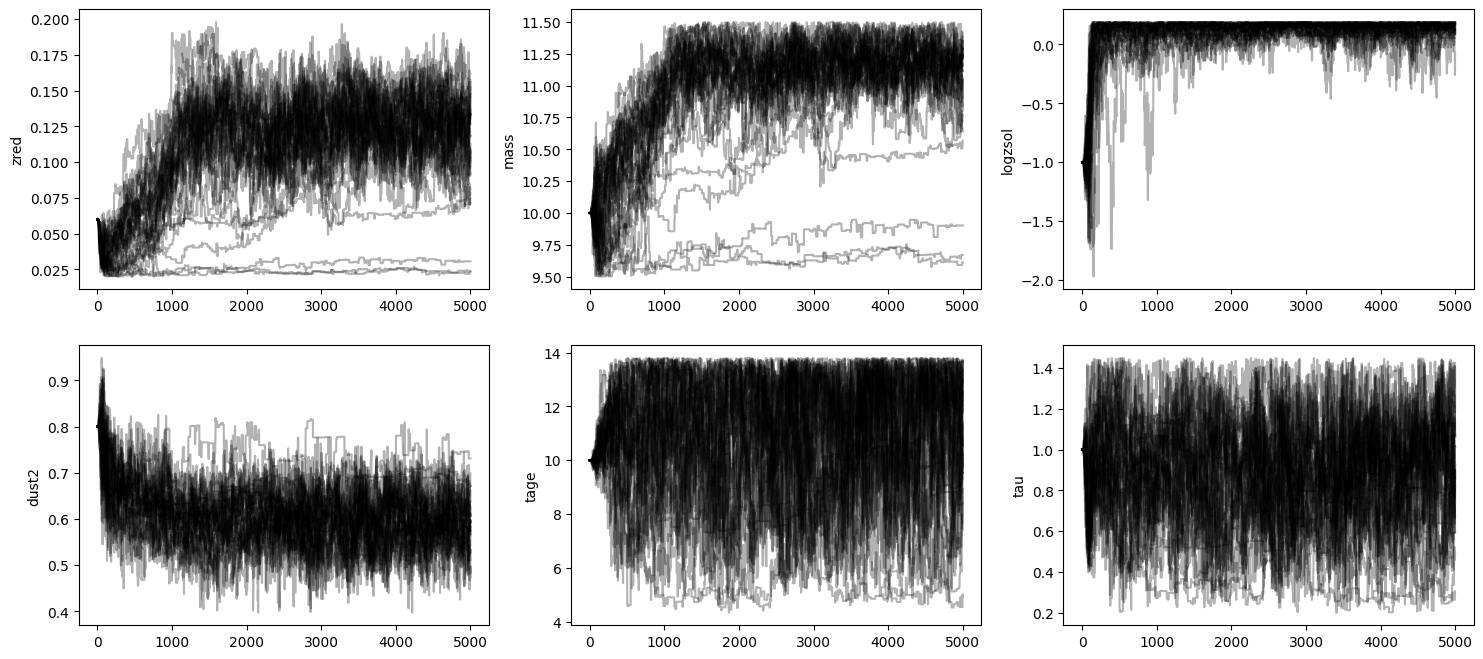

In [24]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

axs[0,0].plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
axs[0,0].set_ylabel(param_names[0])
axs[0,1].plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
axs[0,1].set_ylabel(param_names[1])
axs[0,2].plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)
axs[0,2].set_ylabel(param_names[2])
axs[1,0].plot(sampler.chain[:,:,3].T, '-', color='k', alpha=0.3)
axs[1,0].set_ylabel(param_names[3])
axs[1,1].plot(sampler.chain[:,:,4].T, '-', color='k', alpha=0.3)
axs[1,1].set_ylabel(param_names[4])
axs[1,2].plot(sampler.chain[:,:,5].T, '-', color='k', alpha=0.3)
axs[1,2].set_ylabel(param_names[5])

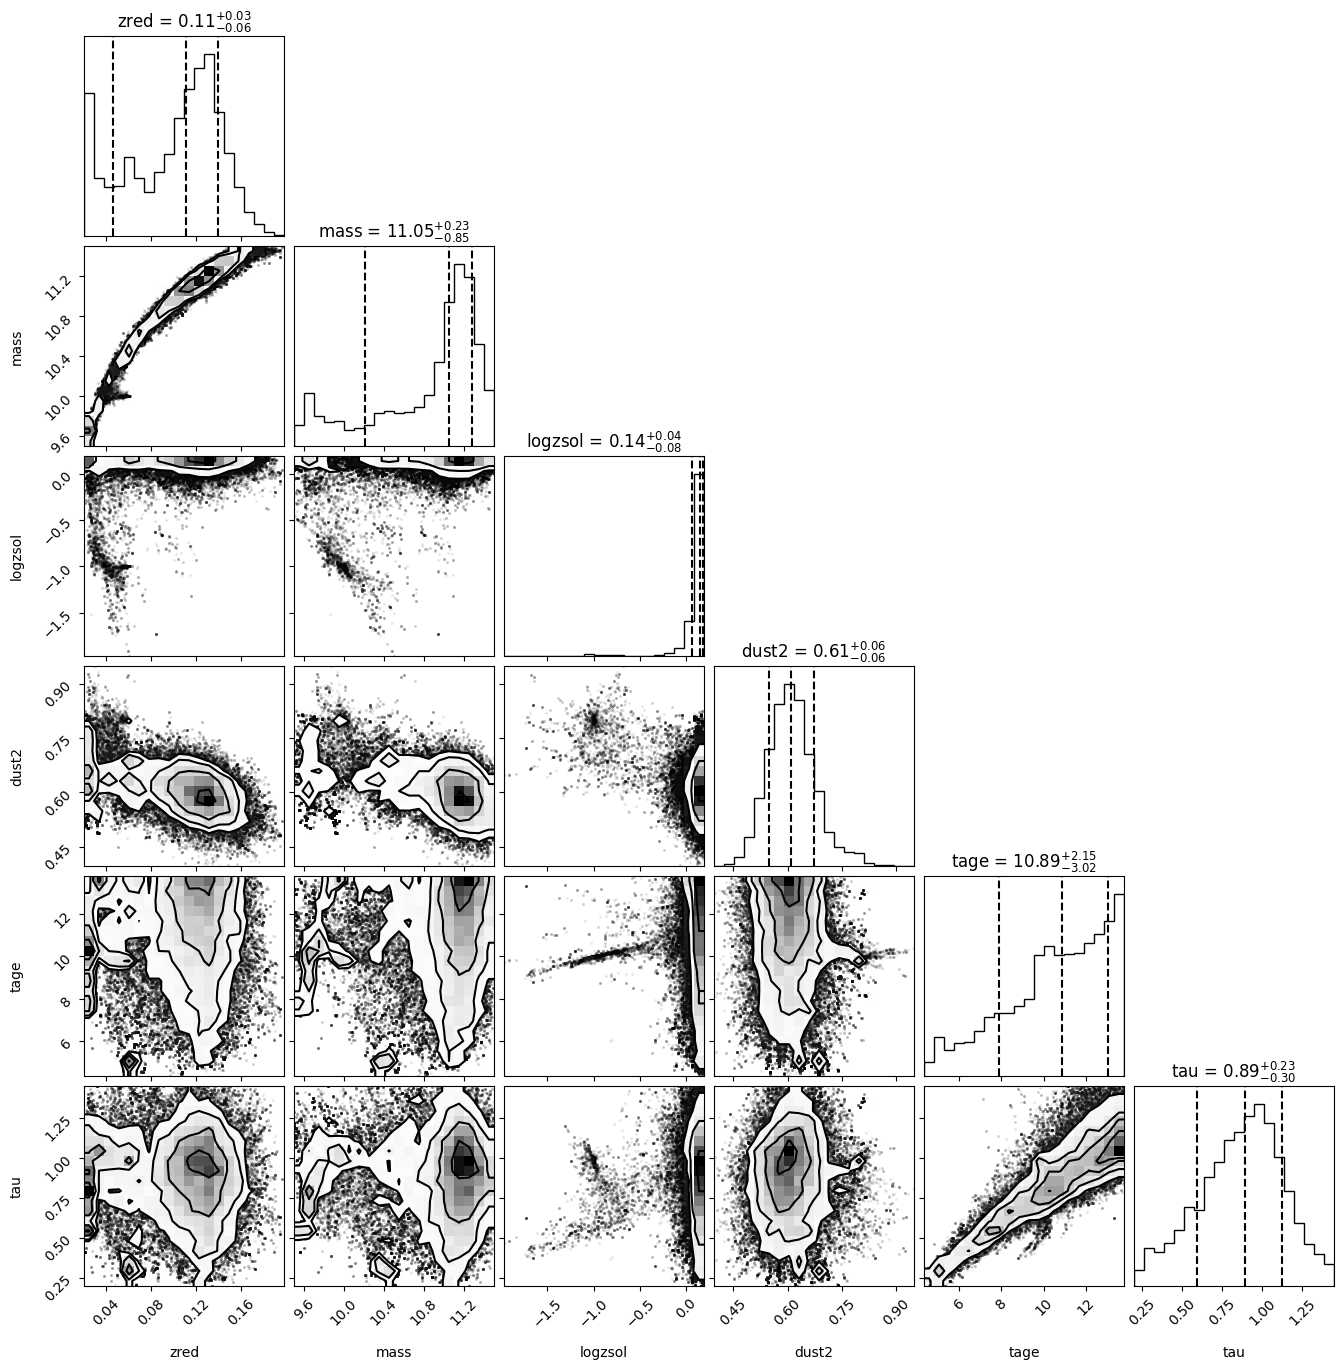

In [25]:
samples = sampler.flatchain
labels = ['zred','mass','logzsol', 'dust2', 'tage', 'tau']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

***Answer:*** Seen above are my emcee results alone. I initially defined my priors based on my results from assignment 1. I found that this produced a good result for mass but reshift was hitting the upper prior. I re-ran a couple times loosening the priors on mass and redshift and found that typically a good result for one was accompanied by the other hitting the top prior. In the final run I showed above, the redshift produced a good result (though the first 1000 points could be thrown out for burn-in, discussed below), but the mass increased and is hitting the upper prior a bit. I think this has to do with the degeneracy between mass and redshift, whereby an object could be small and nearby or massive and far with the same apparent flux.

The dust parameter result was good in every run. I found that the metallicity always immediately hits the top prior, which was an issue with this galaxy in assignment 1 as well. I thought that maybe it needed to not be logged when put into the Prospector model, but as far as I can tell it should be logged as it is. THere is also a degeneracy between $t_{\rm age}$ and $\tau$. I was able to tighten the priors on these parameters a bit after the intial couple runs, but the width of the posteriors is still very large.

These results are now somewhat different from those in assignment 1, and still different from what the published output catalogue suggests.

In [26]:
import dynesty
from dynesty import plotting as dyplot

In [ ]:
print(np.log10(30))
print(np.log10(0.1))

In [27]:
theta_min = np.array([0.02, 9.5, logzsol_min, 0.2, 4, 0.2])
theta_max = np.array([0.2, 11.5, logzsol_max, 1.0, tage_max, 1.45])

def ptform(u):
    x = np.array(u)
    x[0] = x[0]*0.18 + 0.02
    x[1] = x[1]*2. + 9.5
    x[2] = x[2]*2.19 - 2
    x[3] = x[3]*0.8 + 0.2
    x[4] = x[4]*9.8 + 4
    x[5] = x[5]*1.25 + 0.2

    return x



In [28]:
ndim=6
dsampler = dynesty.NestedSampler(lnlike, ptform, ndim, logl_args=(data, err))
dsampler.run_nested(maxiter=5000, print_progress=True)

5001it [42:50,  1.95it/s, +500 | bound: 420 | nc: 1 | ncall: 331701 | eff(%):  1.661 | loglstar:   -inf < -42.149 <    inf | logz: -54.217 +/-  0.268 | dlogz:  0.016 >  0.509]


In [35]:
dsampler.run_nested(maxiter=1000, print_progress=True)

6629it [04:37, 23.91it/s, +500 | bound: 568 | nc: 1 | ncall: 442650 | eff(%):  1.612 | loglstar:   -inf < -41.546 <    inf | logz: -54.147 +/-  0.178 | dlogz:  0.001 >  0.509]


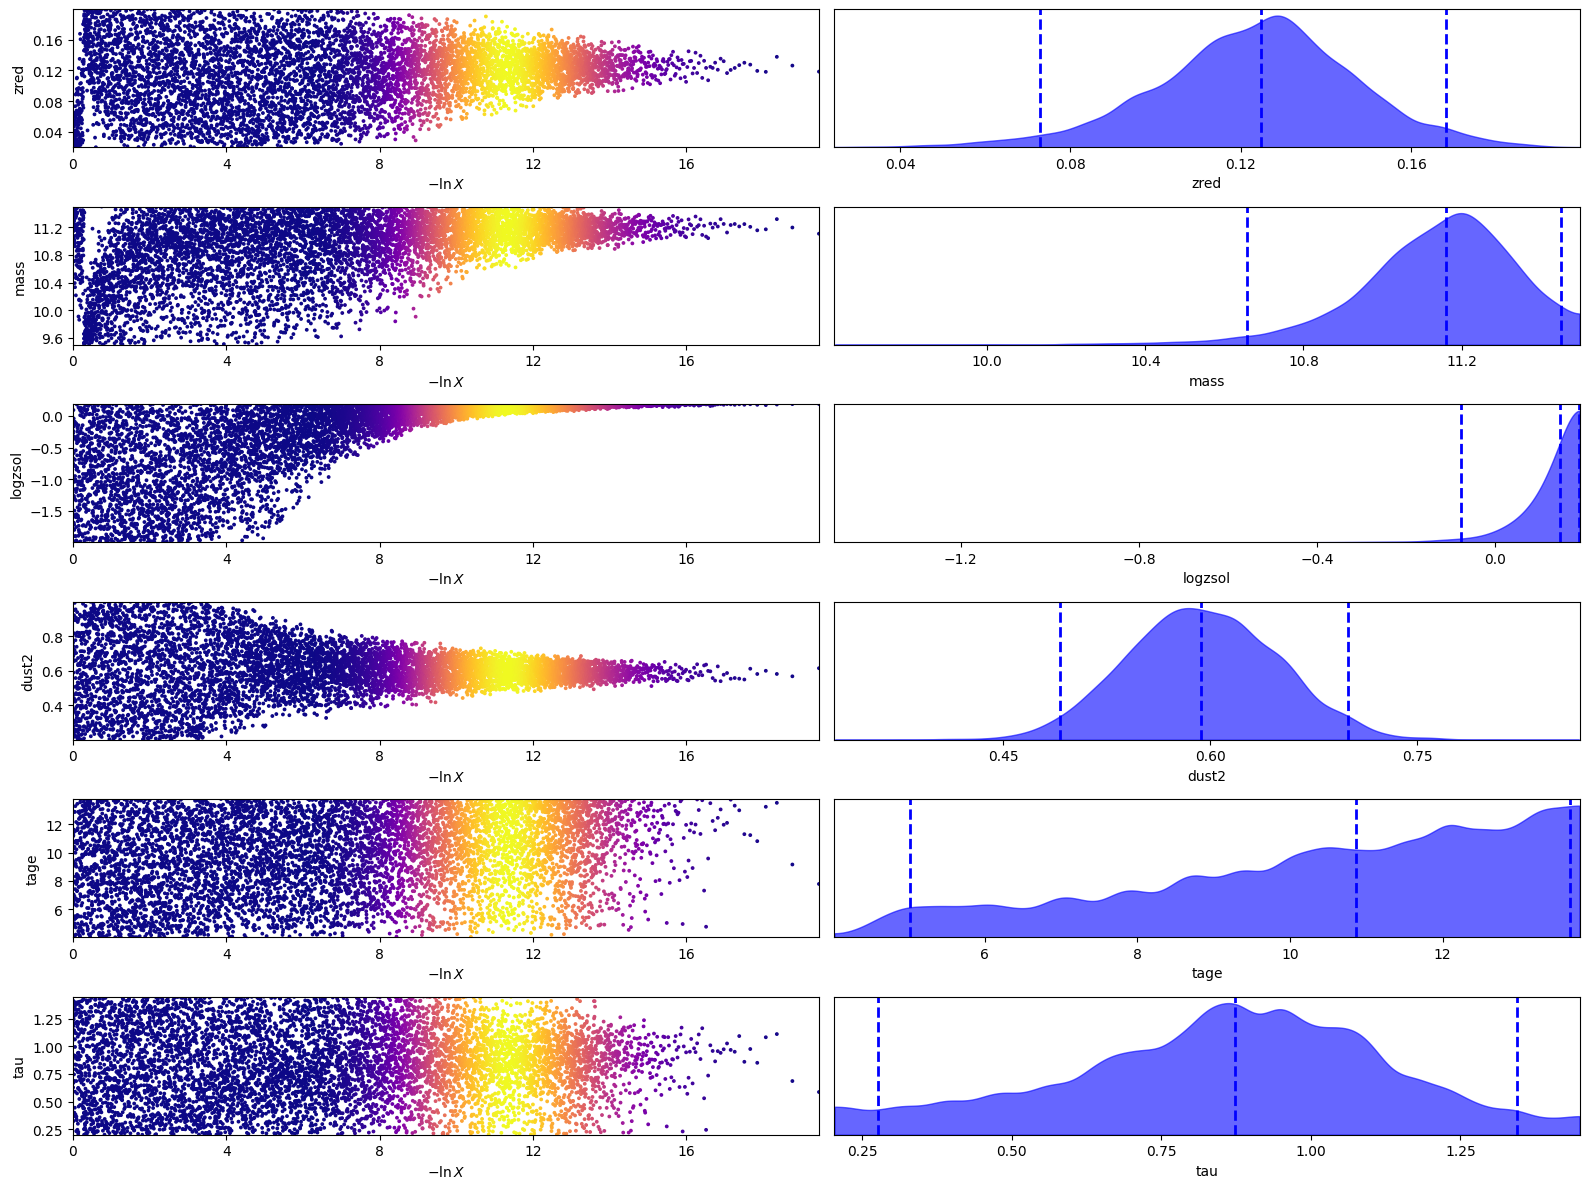

In [36]:
labels = ['zred','mass','logzsol', 'dust2', 'tage', 'tau']

fig, axes = dyplot.traceplot(dsampler.results, labels=labels,
                             fig=plt.subplots(6, 2, figsize=(16, 12)))
fig.tight_layout()

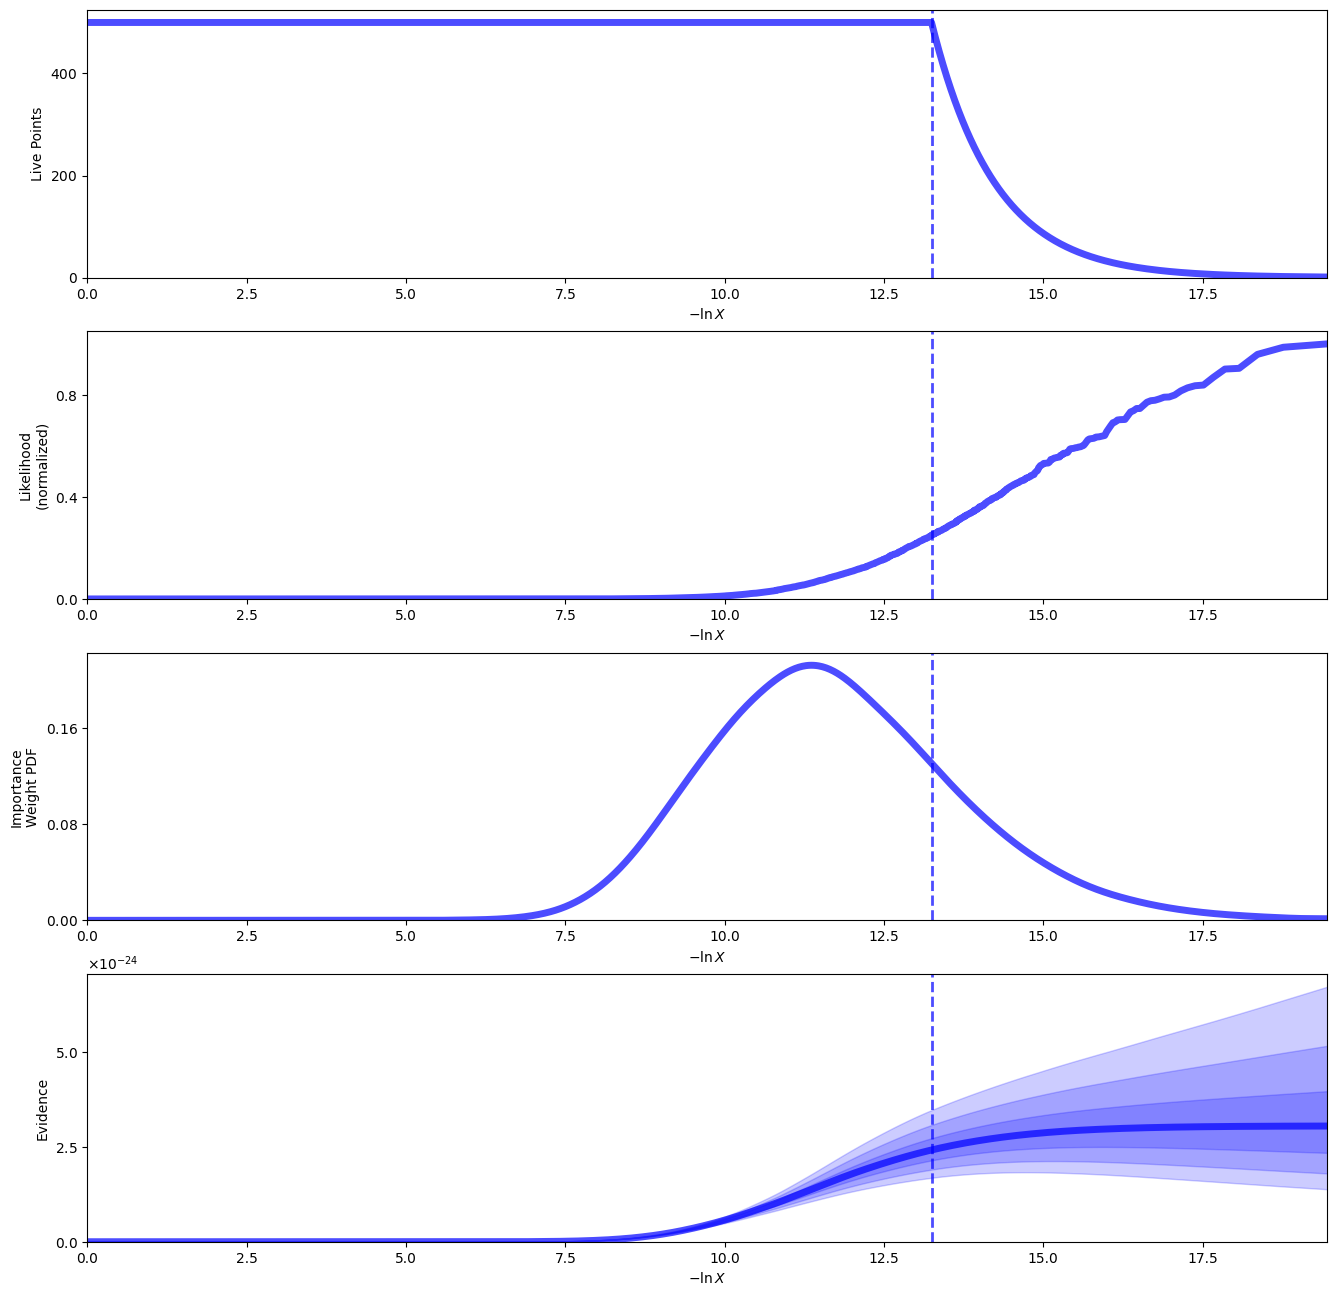

In [37]:
fig, axes = dyplot.runplot(dsampler.results)  # summary (run) plot

***Answer:*** My dynest run did produce similar results to my emcee run using the same priors, which is good!

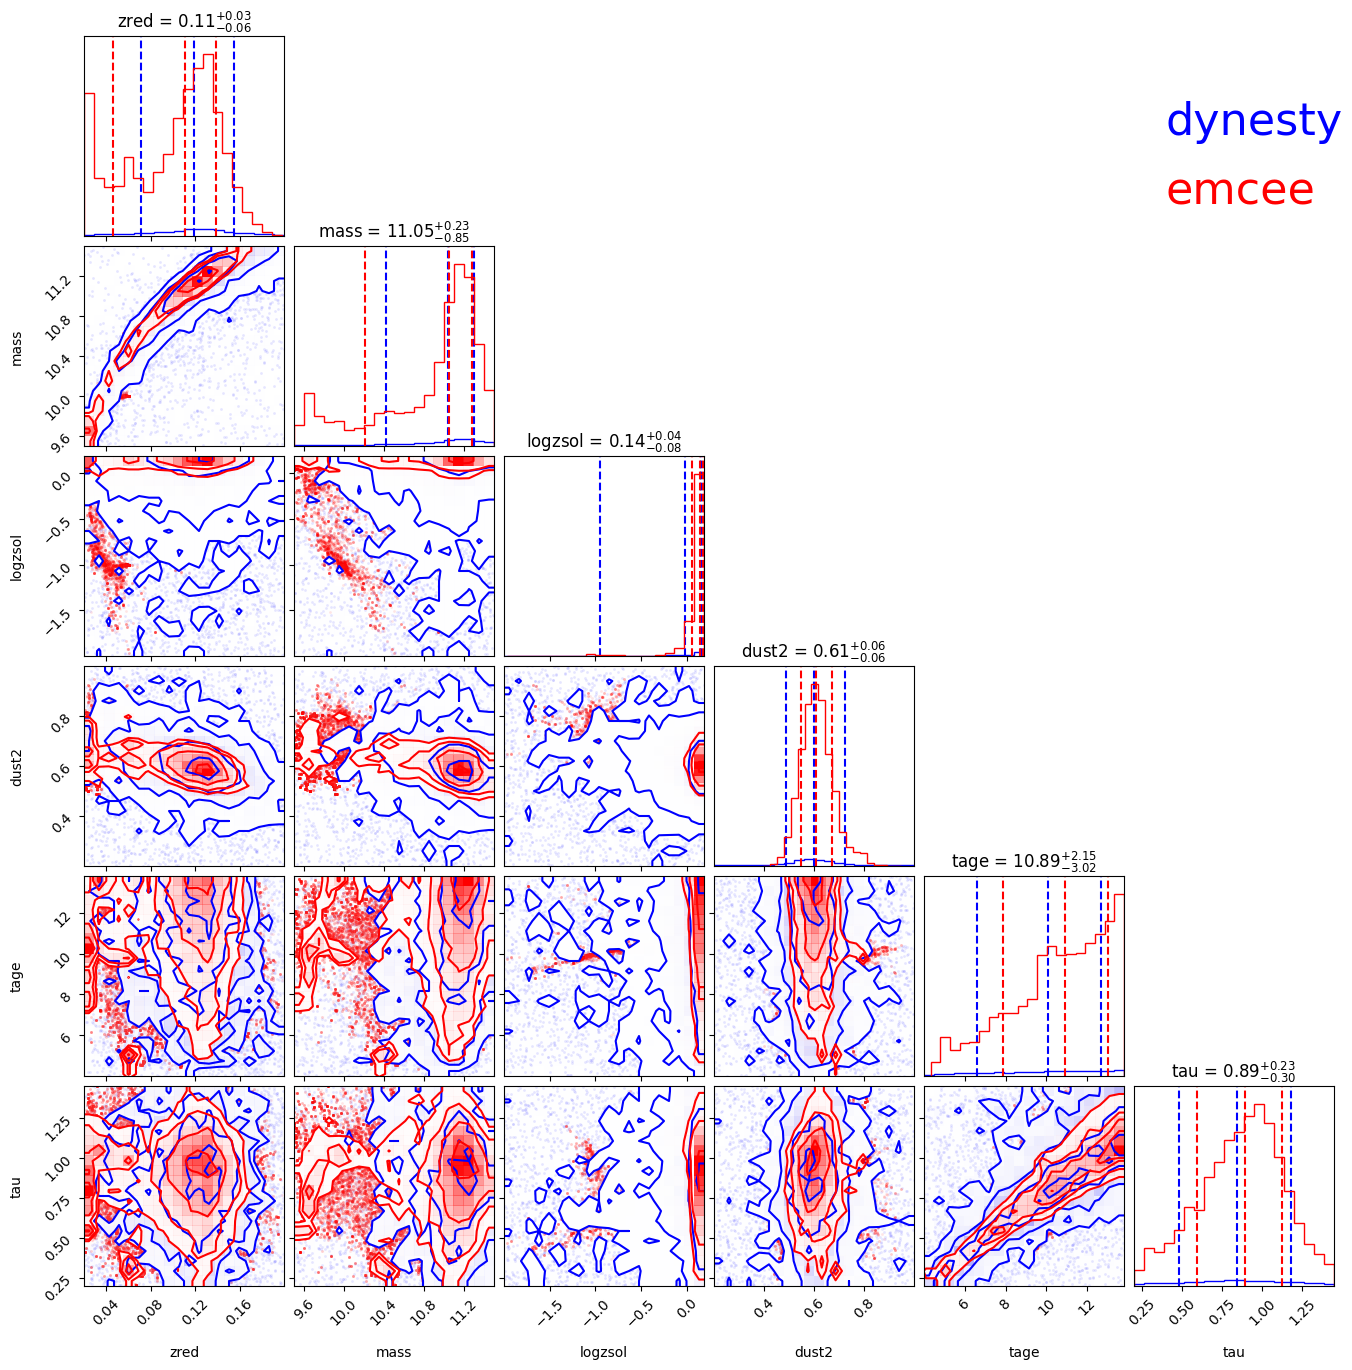

In [38]:

fig = corner.corner(dsampler.results.samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], color='blue')
corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], fig=fig, color='red')
plt.gcf().text(0.85, 0.9, 'dynesty', color='blue', fontsize=32)
plt.gcf().text(0.85, 0.85, 'emcee', color='red', fontsize=32)

plt.show()

***Answer:*** As mentioned above, my dynesty and emcee results are similar. In some cases, the width of the posterior distributions is narrower with dynesty.

In [39]:
import pickle

pickle_path = '/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/'

with open(pickle_path + 'emcee_sampler.pickle', 'wb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pickle.dump(sampler, f)


with open(pickle_path + 'dynesty_sampler.pickle', 'wb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pickle.dump(dsampler, f)

with open(pickle_path + 'dynesty_results.pickle', 'wb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pickle.dump(dsampler.results, f)


In [ ]:
with open(pickle_path + 'dynesty_sampler.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    test_results = pickle.load(f)


3. Did either of your sampling methods have a burn-in? if so make a plot showing the burn-in and justify how much burn-in to remove. If not, explain why there is no burn-in in your methods

(32, 5000, 6)


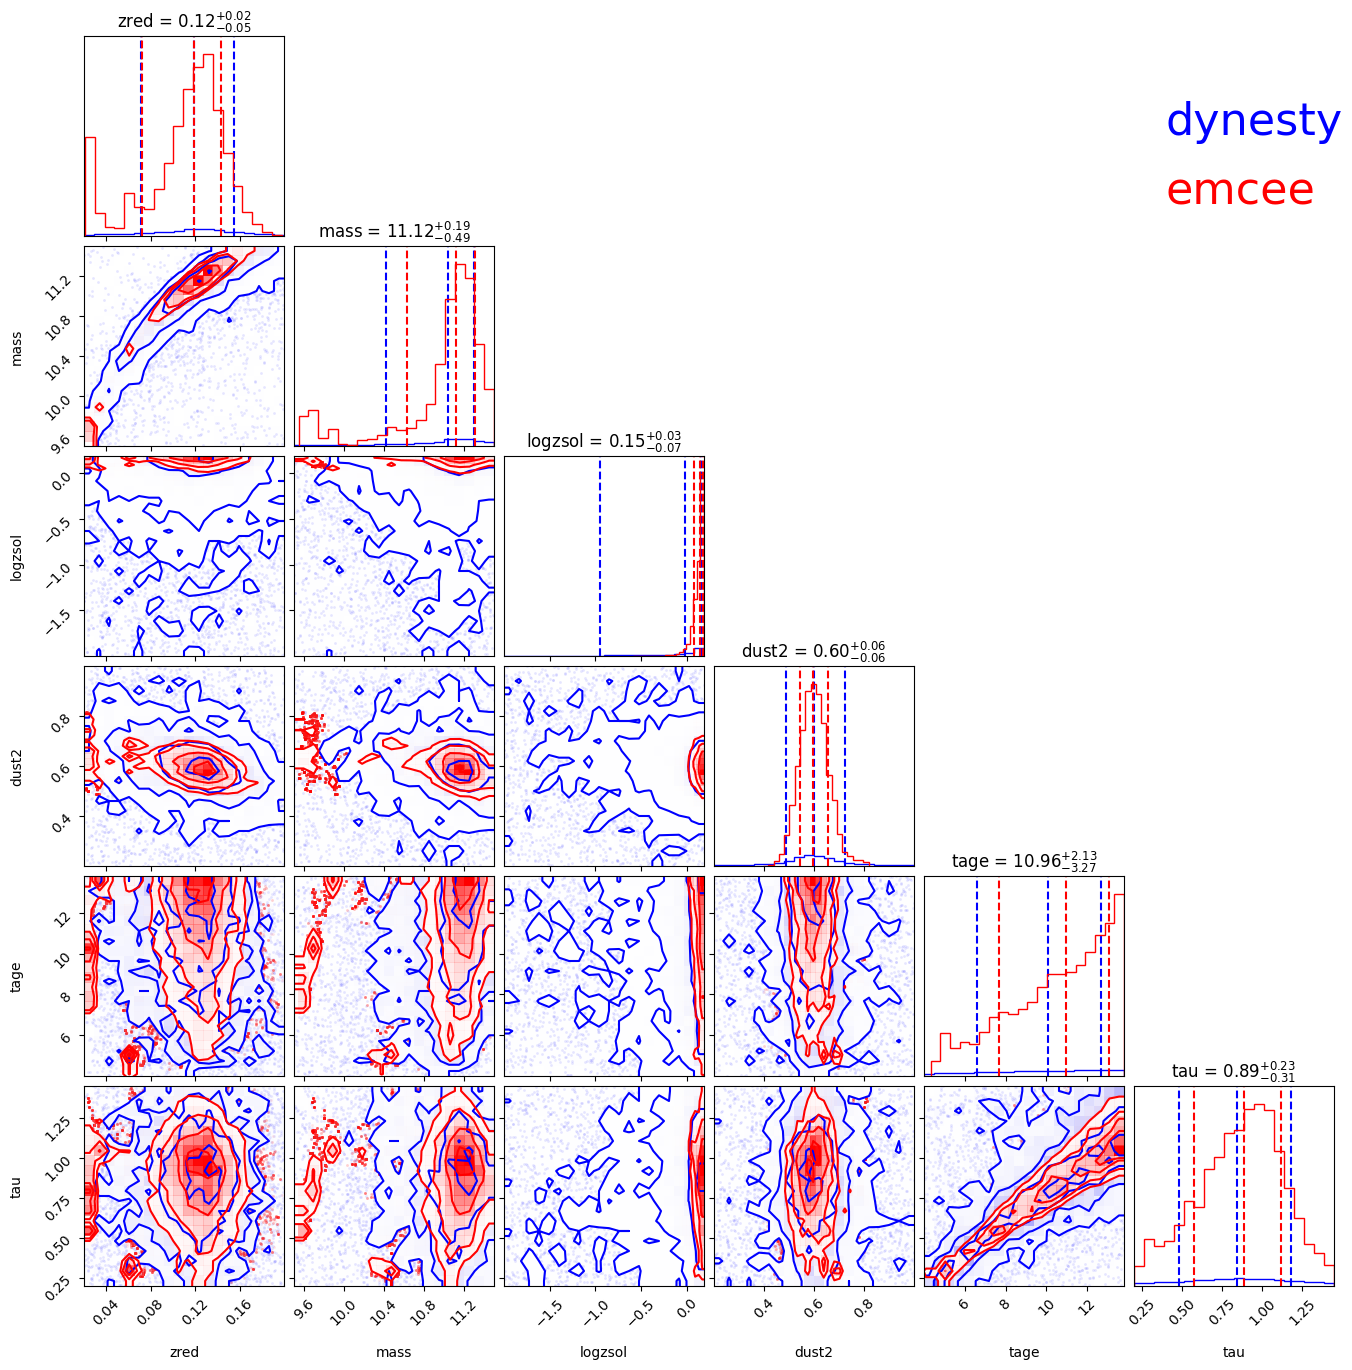

In [44]:
print(sampler.chain.shape)
new_samples = sampler.chain[:,1000:,:]


fig = corner.corner(dsampler.results.samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], color='blue')
corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], fig=fig, color='red')
plt.gcf().text(0.85, 0.9, 'dynesty', color='blue', fontsize=32)
plt.gcf().text(0.85, 0.85, 'emcee', color='red', fontsize=32)

plt.show()

***Answer:*** Using emcee should include a burn-in. As can be seen on my chain plots above, a burn in of about 1000 iterations (or 20 \% of my run) would remove the first bit of the chains where emcee is looking for a minimum to explore the parameter space around. For dynesty, no burn in is required since the nested sampling technique integrates smoothly over the posterior distribution. The sequential sampling allows a given sample to be uncorrelated with the previous sample, meaning burn-in is not required and can actually bias the results. The corner plot above moves the first 1000 iterations from the emcee chains, which cleans up the posterior distribution a bit.

# SECTION 2 - Model Comparison

1. Use the nested sampling technique you chose in Section 1 to compute the Baysian Evidence of your model fit

In [45]:
logz = dsampler.results.logz
logzerr = dsampler.results.logzerr
print(logz[-1], logzerr[-1])



-54.14691088327956 0.26357873634367573


***Answer:*** The log evidence of the dynesty run is -54

2. Change the model in some-way and re-run your nested sampling chain (e.g. add/remove a new parameter, or dramatically change the prior on a parameter)

***Answer:*** I will fix the redshift at the value from the Chang catalogue and re-run the model

In [96]:
from prospect.models import SedModel, priors
from prospect.models.templates import TemplateLibrary
from prospect.sources import CSPSpecBasis
import time

model_params = TemplateLibrary["parametric_sfh"]

print(model_params)


# Let redshift vary
# model_params["zred"]["isfree"] = True
model_params['zred']['init'] = 0.041
# model_params['zred']['prior'] = priors.TopHat(mini=0,maxi=1)

# Build the model
prospector_model = SedModel(model_params)

sps = CSPSpecBasis(zcontinuous=1)

import sedpy 
import prospect
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

gal_id = 44

with fits.open('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

def build_obs(gal_id):
    """Given an object, load in fluxes, convert them to nanomaggies, and create a dict used in Prospector."""

    inp = {}
    
    # Get dataframe row for the object
    row = df.iloc[gal_id]
    inp['redshift'] = row.redshift

    # Load the filter response curves from sedpy
    bands = [f'sdss_{filt}0' for filt in 'ugriz'] + [f'wise_w{n}' for n in range(1,5)]
    filters = sedpy.observate.load_filters(bands)
    inp['filters'] = filters
    
    # Fluxes and uncertainties - already in units of maggies
    cols = [f'flux_{filt}' for filt in 'ugriz'] + [f'flux_w{n}' for n in range(1,5)]
    fluxes = row[cols].values.astype(float) / 3631

    # Errors
    cols_err = [f'{col}_e' for col in cols]
    errs = row[cols_err].values.astype(float) / 3631

    # Anything with a value of 9.999 is null, so may need to mask those fluxes by editing phot_mask
    inp['maggies'] = fluxes
    inp['maggies_unc'] = errs
    inp['phot_mask'] = [True for val in fluxes] # Nothing masked here right now

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    inp["phot_wave"] = np.array([f.wave_effective for f in inp["filters"]])
    inp["wavelength"] = None
    
    # Populate other fields with default
    inp = prospect.utils.obsutils.fix_obs(inp)
    return inp

obs = build_obs(gal_id)

#a random sample from the prospectors default priors (just to make sure the model runs)
random_input_values = np.array([model_params[k]['prior'].sample()[0] for k in model_params.keys() if model_params[k]['isfree']==True])
param_names = np.array([model_params[k]['name'] for k in model_params.keys() if model_params[k]['isfree']==True])
print('Parameters should enter the function in this order:')
print(param_names)

### THIS IS THE FUNCTION YOU CAN USE FOR ALL 
### YOUR MODEL PREDICTIONS FROM THIS POINT
def model(theta):
    return prospector_model.predict(theta, obs=obs, sps=sps)[1]


import scipy.stats
np.random.seed(1)

nsamples = 10

#prior boundaries
# zred_min = 0.0
# zred_max = 1.0
logmass_min = 8.0
logmass_max = 12.0
logzsol_min = -2.0
logzsol_max = 0.19
dust2_min = 0.0
dust2_max = 2.0
tage_min = 0.001
tage_max = 13.8
logtau_min = np.log10(0.1)
logtau_max = np.log10(30)
theta_min = np.array([logmass_min, logzsol_min, dust2_min, tage_min, logtau_min])
theta_max = np.array([logmass_max, logzsol_max, dust2_max, tage_max, logtau_max])

#generate some random input parameter combos
lhc_sampling = scipy.stats.qmc.LatinHypercube(5)
input_params = theta_min + lhc_sampling.random(nsamples) * (theta_max-theta_min)

#un-log the mass and tau 
input_params[:,0] = 10.**input_params[:,0]
input_params[:,4] = 10.**input_params[:,4]

model_evals = np.zeros( (nsamples, obs['ndof']) )
for i in range(nsamples):
    start = time.time()
    model_evals[i] = model(input_params[i])
    finish = time.time()
    print(i, f'{finish-start}s')


{'zred': {'N': 1, 'isfree': False, 'init': 0.1, 'units': 'redshift', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)}, 'mass': {'N': 1, 'isfree': True, 'init': 10000000000.0, 'units': 'Solar masses formed', 'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)}, 'logzsol': {'N': 1, 'isfree': True, 'init': -0.5, 'units': '$\\log (Z/Z_\\odot)$', 'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)}, 'dust2': {'N': 1, 'isfree': True, 'init': 0.6, 'units': 'optical depth at 5500AA', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)}, 'sfh': {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index'}, 'tage': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)}, 'imf_type': {'N': 1, 'isfree': False, 'init': 2}, 'dust_type': {'N': 1, 'isfree': False, 'init': 0}, 'tau': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr^{-1}', 'prior'

In [48]:
data = obs['maggies']
err = obs['maggies_unc']

theta_min = np.array([9.5, logzsol_min, 0.2, 4, 0.2])
theta_max = np.array([11.5, logzsol_max, 1.0, tage_max, 1.45])



def lnlike(theta, data, err):
    theta_model = theta.copy()
    theta_model[0] = 10**theta_model[0]
    theta_model[4] = 10**theta_model[4]
    return -0.5 * np.sum((( data - model(theta_model))/err) ** 2)


def lnprior(theta, theta_min, theta_max):

    if np.all(theta > theta_min) and np.all(theta < theta_max):
        return 0.0
    else:
        return -np.inf
    

def lnprob(theta, data, err, theta_min, theta_max):
    lp = lnprior(theta, theta_min, theta_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data, err)

initial = np.array([10, -1, 0.8, 10, 0.6])

initial2 = initial.copy()
initial2[0] = 10**initial2[0]
initial2[4] = 10**initial2[4]



print(data)
lnprob(initial, data, err, theta_min, theta_max)



[5.71944372e-08 1.48620766e-07 2.22767275e-07 2.88019842e-07
 3.54241244e-07 9.18157544e-07 6.36783282e-07 4.04114562e-06
 1.11772790e-06]


-163.66163468671644

In [50]:
theta_min = np.array([9.5, logzsol_min, 0.2, 4, 0.2])
theta_max = np.array([11.5, logzsol_max, 1.0, tage_max, 1.45])

def ptform(u):
    x = np.array(u)
    # x[0] = x[0]*0.18 + 0.02
    x[0] = x[0]*2. + 9.5
    x[1] = x[1]*2.19 - 2
    x[2] = x[2]*0.8 + 0.2
    x[3] = x[3]*9.8 + 4
    x[4] = x[4]*1.25 + 0.2

    return x

ndim=5
dsampler = dynesty.NestedSampler(lnlike, ptform, ndim, logl_args=(data, err))
dsampler.run_nested(maxiter=2000, print_progress=True)

2001it [02:38, 12.62it/s, +500 | bound: 2 | nc: 1 | ncall: 19647 | eff(%): 13.062 | loglstar:   -inf < -46.891 <    inf | logz: -56.755 +/-  0.660 | dlogz:  0.533 >  0.509]  


In [60]:
dsampler.run_nested(maxiter=1000, print_progress=True)

6005it [01:52, 53.43it/s, +500 | bound: 71 | nc: 1 | ncall: 71240 | eff(%):  9.196 | loglstar:   -inf < -46.020 <    inf | logz: -57.607 +/-  0.178 | dlogz:  0.001 >  0.509]


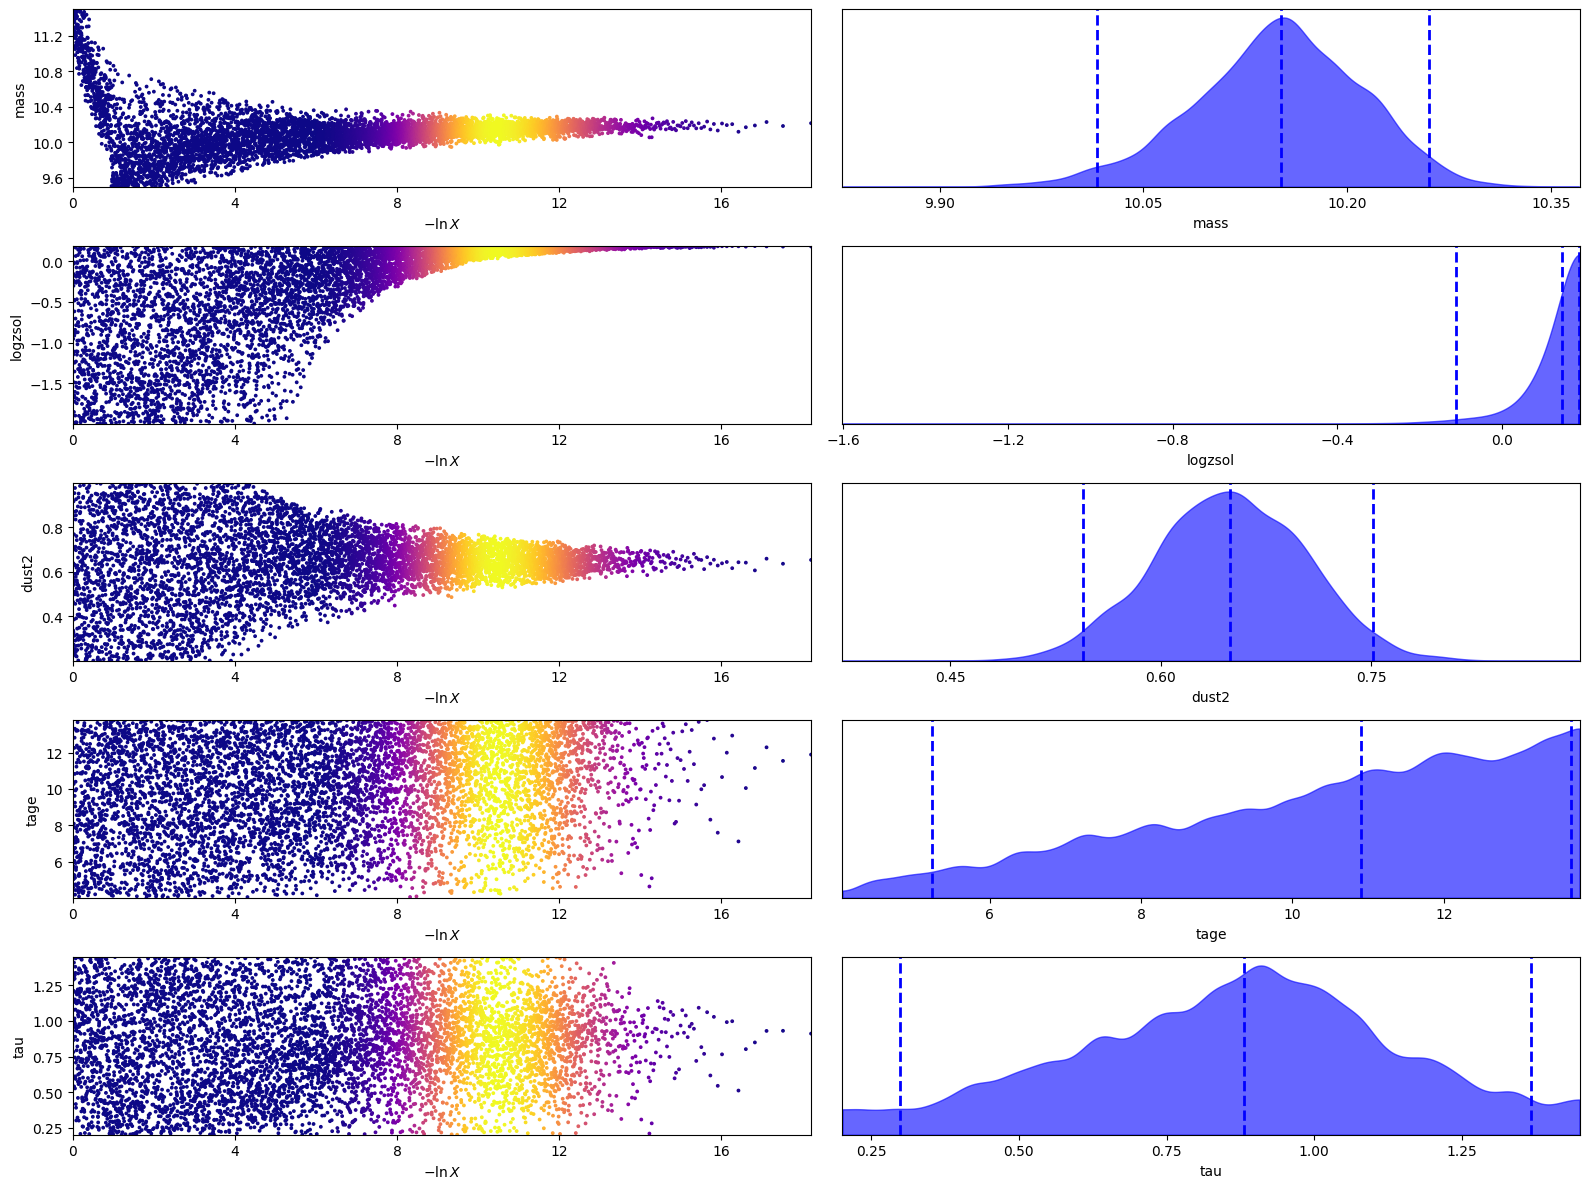

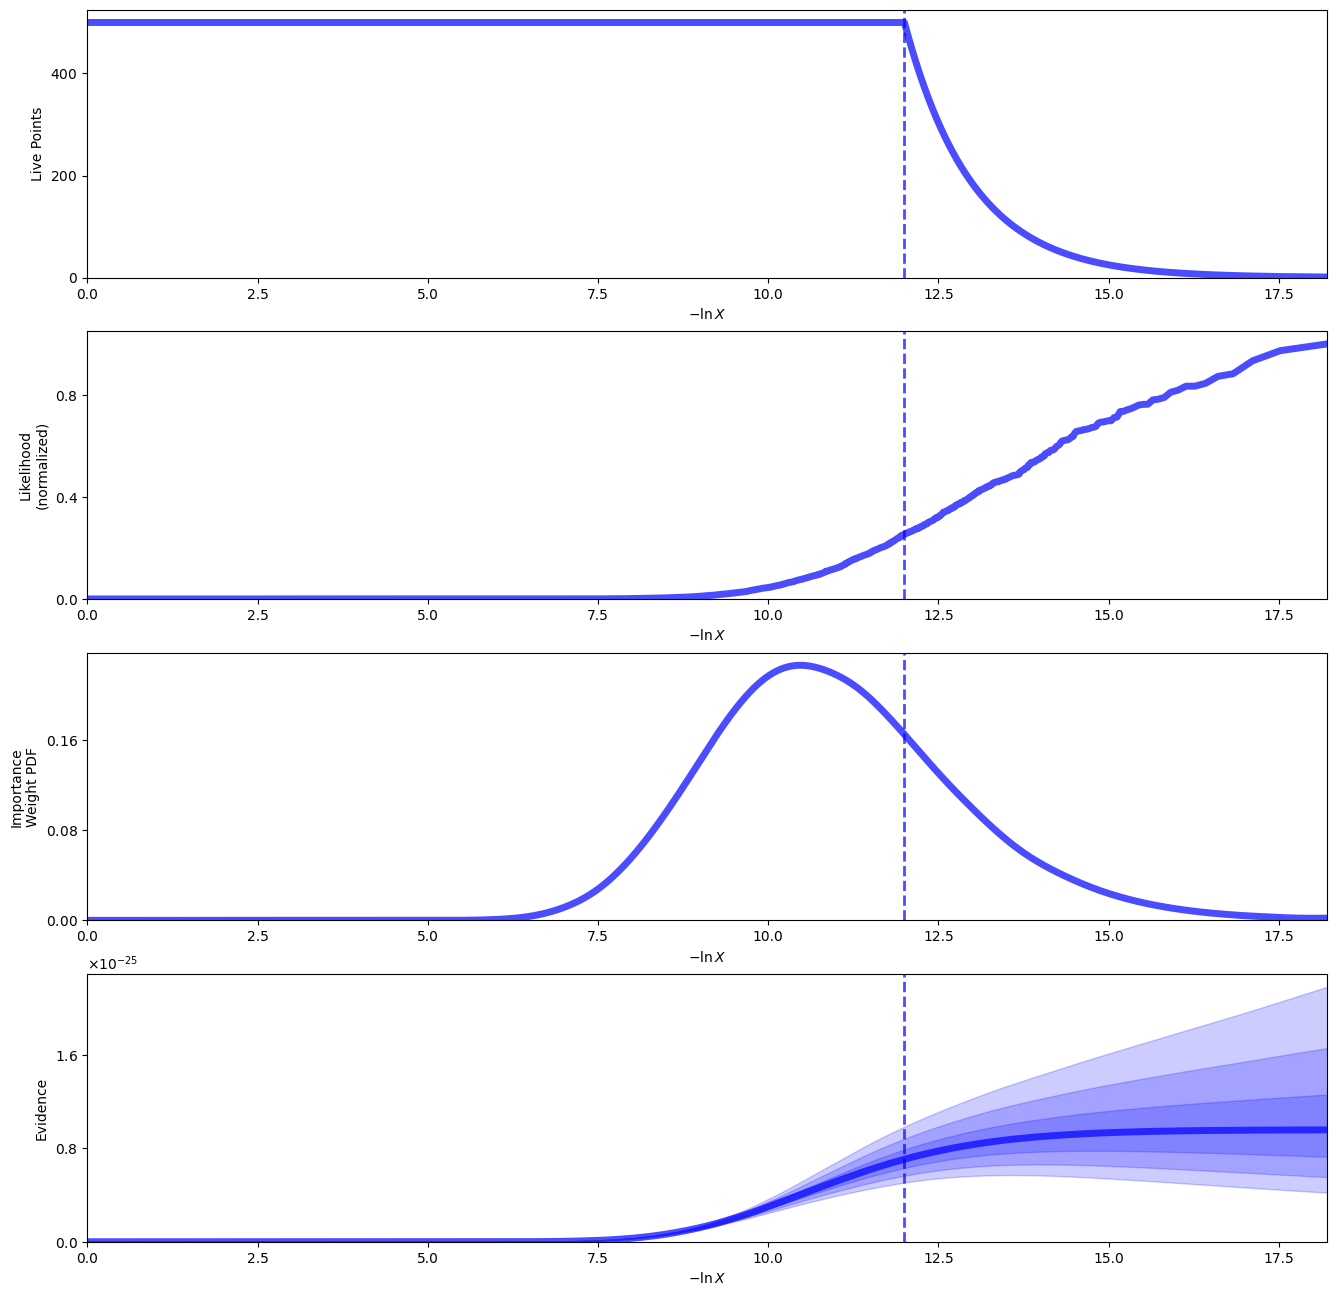

In [61]:
labels = ['mass','logzsol', 'dust2', 'tage', 'tau']

fig, axes = dyplot.traceplot(dsampler.results, labels=labels,
                             fig=plt.subplots(5, 2, figsize=(16, 12)))
fig.tight_layout()

fig, axes = dyplot.runplot(dsampler.results)  # summary (run) plot

In [62]:
with open(pickle_path + 'dynesty_sampler_fix_z.pickle', 'wb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pickle.dump(dsampler, f)

In [64]:
with open(pickle_path + 'dynesty_sampler_fix_z.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    dsampler_fixz = pickle.load(f)

with open(pickle_path + 'dynesty_sampler.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    dsampler = pickle.load(f)

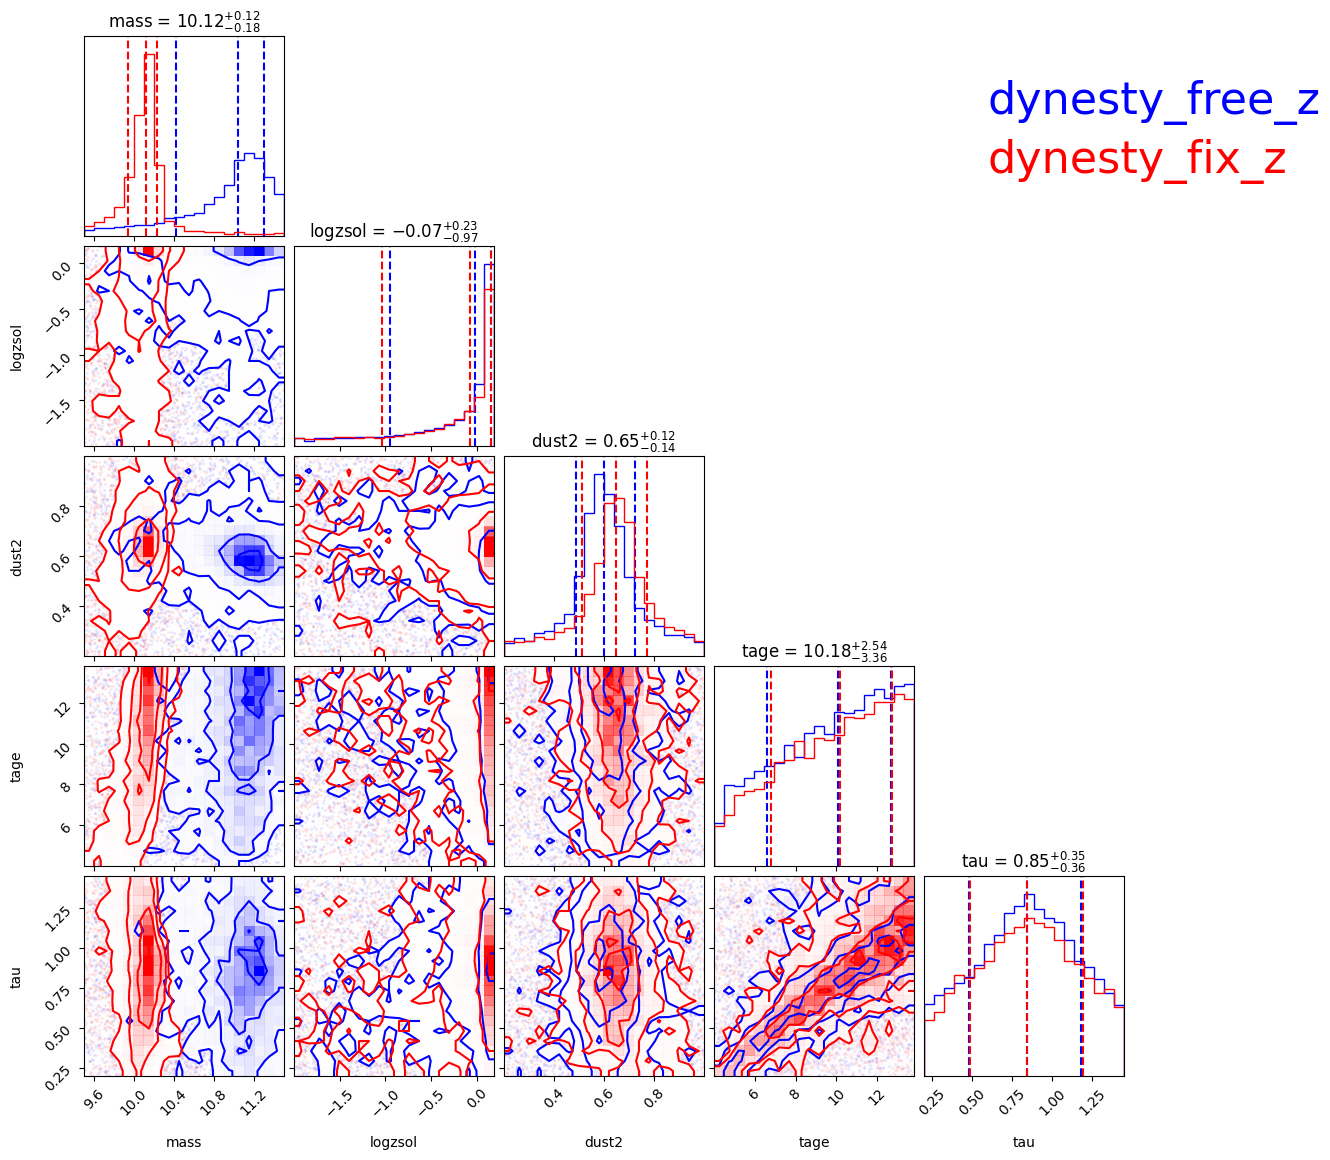

In [71]:
labels = ['mass','logzsol', 'dust2', 'tage', 'tau']

fig = corner.corner(dsampler.results.samples[:, 1:],show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], color='blue')
corner.corner(dsampler_fixz.results.samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], fig=fig, color='red')
plt.gcf().text(0.85, 0.9, 'dynesty_free_z', color='blue', fontsize=32)
plt.gcf().text(0.85, 0.85, 'dynesty_fix_z', color='red', fontsize=32)

plt.show()

***Answer:*** Plotted above are te two dynesty runs on top of each other. The blue is with a free redshift and the red with fixed redshift. For dust, metallicity, t_age and tau the posterior distributions line up very well. However, the stellar mass distributions are quite different, and the fixed redshift stellar mass distribution is much narrower. This makes sense because we have removed the mass-redshift degeneracy.

3. Use a Bayesian model comparison technique to decide which model your data prefer

In [81]:
logz = dsampler.results.logz[-1]
logzerr = dsampler.results.logzerr[-1]

logz_fixz = dsampler_fixz.results.logz[-1]
logzerr_fixz = dsampler_fixz.results.logzerr[-1]

print(np.exp(logz), np.exp(logz_fixz))
print(logzerr*np.exp(logz), np.exp(logz_fixz)*logzerr_fixz)

K = np.exp(logz)/np.exp(logz_fixz)

print(K)

3.049968761932531e-24 9.58260133320536e-26
8.0390691215786165e-25 2.632570577323903e-26
31.828192114847404


***Answer:*** I computed the Bayes factor, taking the ratio of the evidences of the two dynesty runs (free and fixed redshift). The results showed that the data prefer the fit with a free redshift, with a Bayes factor of 32, which is quite high.

# SECTION 3 - Comparing results



1. How do the conclusions from your "Bayesian" model comparison compare to just looking at the change in the best-fit (reduced) chi-squared

In [95]:
def chisquare(obs, exp, sig):
    return np.sum((obs-exp)**2 / sig**2)


print(dsampler.results.samples.shape)
free_z_med = np.median(dsampler.results.samples, axis=0)
free_z_med[1] = 10**free_z_med[1]
free_z_med[5] = 10**free_z_med[5]

print(model(free_z_med))

Xsq = chisquare(data, model(free_z_med), err)




(7129, 6)
[5.21706740e-08 1.31798544e-07 2.10870478e-07 2.58894210e-07
 3.40775378e-07 3.75395433e-07 2.45998699e-07 1.83668048e-06
 2.18332322e-06]
105.69222240931363


In [102]:
redXsq_free = Xsq/(9 - 6)

In [103]:
print(dsampler_fixz.results.samples.shape)
fix_z_med = np.median(dsampler_fixz.results.samples, axis=0)
fix_z_med[0] = 10**fix_z_med[0]
fix_z_med[4] = 10**fix_z_med[4]

print(model(fix_z_med))

redXsq_fixed = chisquare(data, model(fix_z_med), err)/(len(data) - len(fix_z_med))

print(redXsq_fixed)

(6505, 5)
[5.72499588e-08 1.56016348e-07 2.32845276e-07 2.92739458e-07
 3.81523145e-07 3.73205297e-07 2.31139571e-07 2.00475835e-06
 2.47161252e-06]
25.45355126138618


In [104]:
print(redXsq_free, redXsq_fixed)

35.230740803104545 25.45355126138618


***Answer:*** My reduced chi-squared values are pretty bad for both fits, and comparable to the results from assignment 1. However, the value for the fixed redshift model is somewhat better. This is contradictory to what the Bayes factor suggests

2. How do your experiences of inferring galaxy properties from MCMC compare to your inference using Machine Learning (Assignment 2 - Section 3)

* Which one was more accurate?
* What are their limitations?
* What unique infomation did the different approaches provide?

***Answer:*** I found that with ML from assignment 2 I was able to better predict mass and redshift without much degeneracy. However, ML models are limited by the training set, and proven by the last question on assignment 2, where a set of post starburst galaxies were run and the resulting fits were poor due to their under-representation in the training data. MCMC fits, on the other hand, can take a long time. I was able to train a linear regression model on 9000 galaxies and test it on 1000 in a matter of minutes, where one MCMC fit for a single galaxy took closer to an hor, depending on the parameter constraints. With MCMC routines, you can explore the whole parameter space which can provide valuable statistical information about your parameters that might be harder to obtain with ML techniques.